In [31]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import warnings
warnings.filterwarnings('ignore')
import pyodbc
print(pyodbc.drivers())

['SQL Server', 'ODBC Driver 17 for SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']


In [32]:
# Data Load
connection=pyodbc.connect("Driver={ODBC Driver 17 for SQL Server};"
                    "Server=SNEHA;"
                    "Database=customer_churn;"
                    "Trusted_Connection=yes;")
query='select * from vw_churndata'
data=pd.read_sql(query,connection)
connection.close()
data.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,12505-GUJ,Male,29,No,Gujarat,0,7,Missing,Yes,No,...,Bank Withdrawal,95.650002,167.300003,0.0,0,33.520000,200.820007,Churned,Dissatisfaction,Limited range of services
1,12510-MAH,Male,44,Yes,Maharashtra,14,33,Deal 1,Yes,Yes,...,Bank Withdrawal,112.250000,8041.649902,0.0,0,839.520020,8881.169922,Stayed,Others,Others
2,12511-DEL,Male,50,Yes,Delhi,2,18,Missing,Yes,Yes,...,Bank Withdrawal,78.400002,1832.400024,0.0,130,758.880005,2721.280029,Stayed,Others,Others
3,12513-MAH,Female,18,No,Maharashtra,3,3,Missing,Yes,Yes,...,Bank Withdrawal,104.699997,6333.799805,0.0,150,2128.199951,8612.000000,Stayed,Others,Others
4,12516-TAM,Female,25,Yes,Tamil Nadu,3,30,Deal 3,Yes,No,...,Bank Withdrawal,101.400002,3143.649902,0.0,0,600.780029,3744.429932,Stayed,Others,Others


In [33]:
# Droping columns that are irrelevant to the prediction
data=data.drop(['Customer_ID','Churn_Category','Churn_Reason'],axis=1)

# Encoding categorical variables except the target variable
le=LabelEncoder()
for col in data.columns:
    if data[col].dtype=='object' and col!= "Customer_Status":
        data[col]=le.fit_transform(data[col])
        
# Manually encoding the target variable 'Customer_Status'
data['Customer_Status']=data['Customer_Status'].map({'Stayed': 0,'Churned': 1})

In [34]:
# Spliting data into features and target
x=data.drop('Customer_Status',axis=1)
y=data['Customer_Status']
# Spliting data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
# Initializing the Random Forest Classifier and training the model
model=RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)
y_pred=model.predict(x_test)
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[789  64]
 [123 226]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       853
           1       0.78      0.65      0.71       349

    accuracy                           0.84      1202
   macro avg       0.82      0.79      0.80      1202
weighted avg       0.84      0.84      0.84      1202



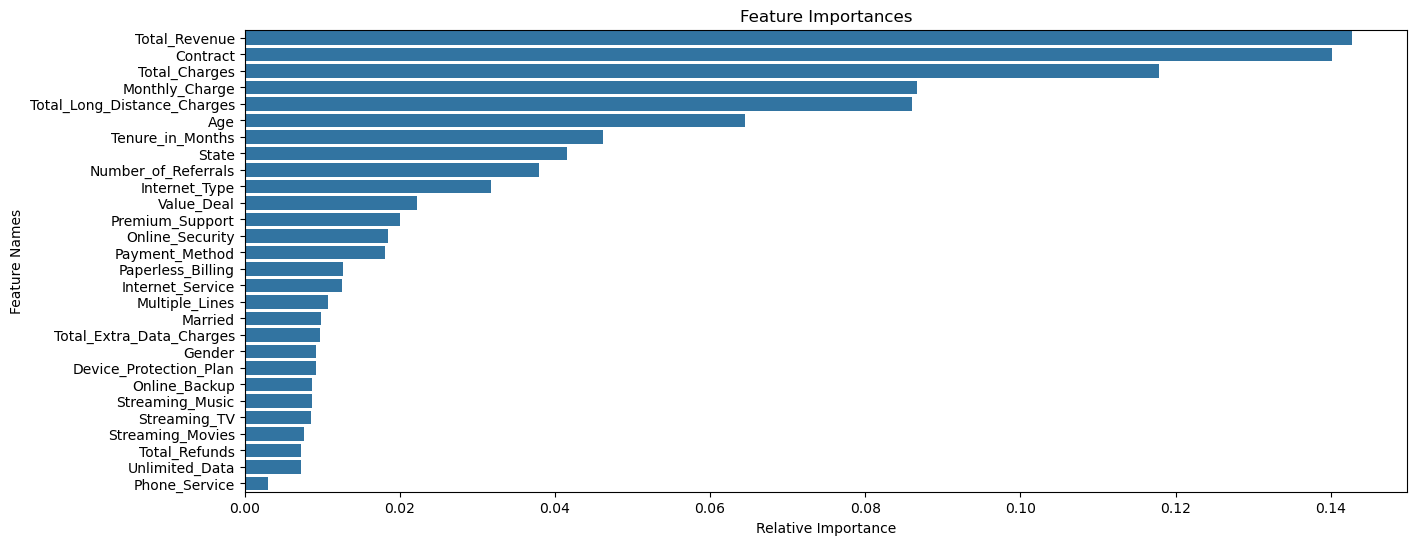

In [35]:
# Feature Selection using Feature Importance
importances=model.feature_importances_
indices=np.argsort(importances)[::-1]
# Ploting the feature importances
plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=x.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()

In [36]:
# Using this Model for Prediction on Joined Data
# Data Load
connection=pyodbc.connect("Driver={ODBC Driver 17 for SQL Server};"
                    "Server=SNEHA;"
                    "Database=customer_churn;"
                    "Trusted_Connection=yes;")
query='select * from vw_joindata'
new_data=pd.read_sql(query,connection)
connection.close()

In [37]:
# Keeping the original DataFrame ensures the unencoded columns are still in their original form
original_data=new_data.copy()
customer_ids=new_data['Customer_ID']

In [ ]:
# Droping columns that won't be used for prediction in the encoded DataFrame
new_data=new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)
for col in new_data.columns:
    if new_data[col].dtype=='object':
        new_data[col]=le.fit_transform(new_data[col])
# Making predictions
new_predictions=model.predict(new_data)
original_data['Customer_Status_Predicted'] = new_predictions
original_data['Customer_ID'] = customer_ids
# Filtering the DataFrame to include only records predicted as "Churned"
original_data=original_data[original_data['Customer_Status_Predicted'] == 1]

In [17]:
# Saving the results
original_data.to_csv("E:\Projects\Customer Churn\Predictions.csv", index=False)